In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn import tree
from sklearn.preprocessing import FunctionTransformer

In [16]:
data = pd.read_csv('01_data.csv', index_col=0, parse_dates=True)
data.head()

,precip_in,q_cfs_BT_int,q_cfs_SC_int,cy,month,wy,D0,D1,D2,D3,D4,wildfire_percent
2008-10-01 00:00:00,0.0,10.8,1.43,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-01 00:15:00,0.0,10.8,1.26,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-01 00:30:00,0.0,10.8,1.26,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-01 00:45:00,0.0,10.8,1.26,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-01 01:00:00,0.0,10.8,1.26,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0


In [30]:
data_rfr['q_cfs_SC_int'].diff(1)

2008-10-01 00:00:00     NaN
2008-10-01 00:15:00   -0.17
2008-10-01 00:30:00    0.00
2008-10-01 00:45:00    0.00
2008-10-01 01:00:00    0.00
                       ... 
2024-02-19 10:00:00    0.00
2024-02-19 10:15:00    0.00
2024-02-19 10:30:00    0.00
2024-02-19 10:45:00    0.00
2024-02-19 11:00:00    0.00
Name: q_cfs_SC_int, Length: 539469, dtype: float64

## Random Forest Model
Build Random forest model with several variables lagged, to get general idea of feature importance and model fit capabilities as a baseline. 

In [64]:
data_rfr = data.copy()
months_to_lag = [1, 2, 3, 4]
drought_index_ints = [0, 1, 2, 3, 4]

for m in months_to_lag:
    data_rfr['lag_precip_' + str(m) + 'months'] = data_rfr.precip_in.shift(-30*96*m) # shift data back, 96 15-min intervals in one day, 30 days in a month
    for d in drought_index_ints:
        data_rfr['lag_d' + str(d) + '_' + str(m) + 'months'] = data_rfr['D' + str(d)].shift(-30*93*m) #shift back data

hours_to_lag = [1, 2, 4, 6, 12]
for h in hours_to_lag:
    data_rfr['lag_precip_' + str(h) + 'hours'] = data_rfr.precip_in.shift(-4*h) # shift data back h hours


data_rfr.dropna(inplace=True) #drop null values created with shift functions - will be most recent 4 months
data_rfr.head()


,precip_in,q_cfs_BT_int,q_cfs_SC_int,cy,month,wy,D0,D1,D2,D3,...,lag_d0_4months,lag_d1_4months,lag_d2_4months,lag_d3_4months,lag_d4_4months,lag_precip_1hours,lag_precip_2hours,lag_precip_4hours,lag_precip_6hours,lag_precip_12hours
2008-10-01 00:00:00,0.0,10.8,1.43,2008,10,2009,100.0,100.0,0.0,0.0,...,100.0,100.0,8.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-01 00:15:00,0.0,10.8,1.26,2008,10,2009,100.0,100.0,0.0,0.0,...,100.0,100.0,8.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-01 00:30:00,0.0,10.8,1.26,2008,10,2009,100.0,100.0,0.0,0.0,...,100.0,100.0,8.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-01 00:45:00,0.0,10.8,1.26,2008,10,2009,100.0,100.0,0.0,0.0,...,100.0,100.0,8.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-01 01:00:00,0.0,10.8,1.26,2008,10,2009,100.0,100.0,0.0,0.0,...,100.0,100.0,8.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0


training model score:  0.29719387578864753
test model score:  0.30312805166914725


<Axes: >

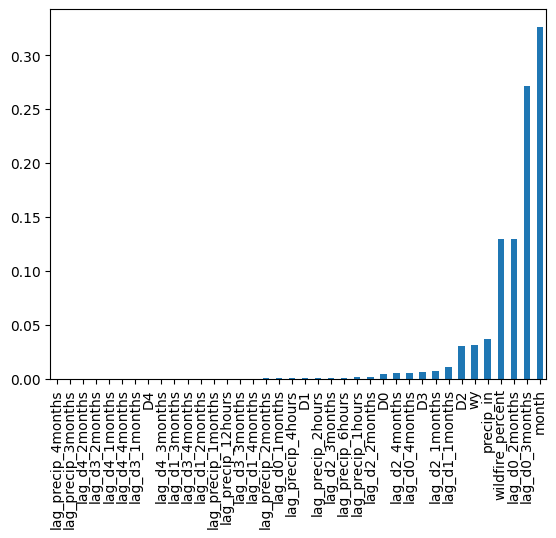

In [65]:
X = data_rfr.drop(['q_cfs_SC_int', 'q_cfs_BT_int', 'cy'], axis=1)
y = data_rfr['q_cfs_SC_int']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

rfr = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=777)
rfr.fit(X_train, y_train)
print('training model score: ', rfr.score(X_train, y_train))
print('test model score: ', rfr.score(X_test, y_test))

#next, we'll take a look at feature importance
importances = rfr.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.sort_values().plot.bar(ax=ax)


training model score:  0.3029006420940836
test model score:  0.30753715669242454


<Axes: >

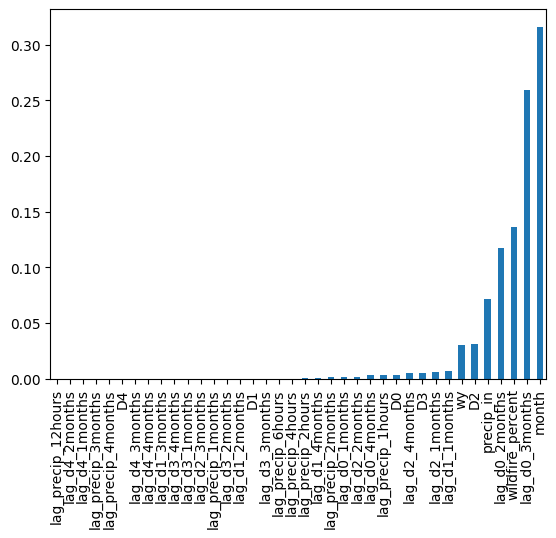

In [66]:
X = data_rfr.drop(['q_cfs_SC_int', 'q_cfs_BT_int', 'cy'], axis=1)
y = data_rfr['q_cfs_BT_int']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

rfr = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=777)
rfr.fit(X_train, y_train)
print('training model score: ', rfr.score(X_train, y_train))
print('test model score: ', rfr.score(X_test, y_test))

#next, we'll take a look at feature importance
importances = rfr.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.sort_values().plot.bar(ax=ax)


## RFR Results
Most importance features are: 
- month (likely a proxy for time in the season and wet up)
- lag d0 3 months: abnormally dry (least amount of drought) but lagged 3 months (and 2 months)
- wildfire percent: this is interesting as only 2 of 16 years had a fire, and the feature acts as an indicator of whether a fire occured in that year or not (and how severe) - fire obviously has a big impact on runoff.
- precip_in: interesting that this landed pretty far down on the list. Obviously this is just the precip from the last 15 min interval. Interestingly, lagged hourly precip doesn't seem to matter much.

RFR model appears to explain 30% of model variability (R_squared)